# SET UP

In [2]:
!pip install darts==0.27.0 optuna==3.5.0 shap==0.44.0 miceforest==5.7.0 pandas==2.1.2 xarray==2023.11.0 lightgbm==4.1.0 dask==2023.7.1

  Using cached darts-0.27.0-py3-none-any.whl.metadata (48 kB)
  Using cached optuna-3.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached shap-0.44.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached miceforest-5.7.0-py3-none-any.whl.metadata (43 kB)
  Using cached xarray-2023.11.0-py3-none-any.whl.metadata (11 kB)
  Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Using cached dask-2023.7.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached nfoursid-1.0.1-py3-none-any.whl (16 kB)
  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached pyod-1.1.2-py3-none-any.whl
  Using cached statsforecast-1.7.0-py3-none-any.whl.metadata (27 kB)
  Using cached statsmodels-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached tbats-1.1.3-py3-none-any.whl (

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os
import seaborn as sns
import numpy as np




import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")
import optuna
import shap


In [4]:
shap.initjs()

# Global variables

In [5]:
import os

# Get the current working directory
current_directory = os.getcwd()

In [6]:
insert_date_ci='2023-11-21'

In [7]:
daily_aggregated_path=f'{current_directory}/inputs_retraining/{insert_date_ci}/daily_NPS_{insert_date_ci}.csv'

# Load dataset

In [8]:
merged_df=pd.read_csv(daily_aggregated_path)
merged_df.tail()

,date_flight_local,year,month,day,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,...,inm_400_issues_response_not_nulls,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
16811,2023-10-29,2023,10,29,Premium Economy,LH,57.894737,4.74166,1.01607,6.43511,...,3,33.333333,16.0,5.033223,5.333333,3,33.333333,90.758294,77.192982,84.210526
16812,2023-10-30,2023,10,30,Premium Economy,LH,26.086957,4.40297,2.37083,7.78987,...,6,0.000000,33.0,2.302173,6.600000,5,40.000000,78.229665,68.421053,80.701754
16813,2023-10-30,2023,10,30,Premium Economy,LH,26.086957,4.40297,2.37083,7.78987,...,6,0.000000,33.0,2.302173,6.600000,5,40.000000,78.229665,68.421053,80.701754
16814,2023-10-31,2023,10,31,Premium Economy,LH,47.826087,5.08035,1.35476,7.78987,...,1,0.000000,42.0,3.577709,8.400000,5,80.000000,83.705357,91.379310,79.310345
16815,2023-10-31,2023,10,31,Premium Economy,LH,47.826087,5.08035,1.35476,7.78987,...,1,0.000000,42.0,3.577709,8.400000,5,80.000000,83.705357,91.379310,79.310345


In [9]:
last_date = merged_df['date_flight_local'].iloc[-1]

In [10]:
merged_df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)

In [11]:
grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
grouped = merged_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    grouped_dfs[group_df_name] = group_df

In [12]:
for key in grouped_dfs.keys():
    df = grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2022, 2023])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    grouped_dfs[key] = df

In [13]:
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

,date_flight_local,year,month,day,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,...,inm_400_issues_response_mean,inm_400_issues_response_not_nulls,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
0,2021-01-01,2019,1,1,Business,LH,93.136624,1.533603,0.000000,1.533603,...,NaN,0,19.0,1.527525,6.333333,3,44.733333,61.131794,82.978723,76.595745
1,2021-01-01,2019,1,1,Business,LH,93.136624,1.533603,0.000000,1.533603,...,NaN,0,19.0,1.527525,6.333333,3,44.733333,61.131794,82.978723,76.595745
2,2021-01-02,2019,1,2,Business,LH,23.136624,3.067206,1.533603,5.112010,...,NaN,0,47.0,2.948971,5.875000,8,48.900000,75.093168,70.909091,81.818182
3,2021-01-02,2019,1,2,Business,LH,23.136624,3.067206,1.533603,5.112010,...,NaN,0,47.0,2.948971,5.875000,8,48.900000,75.093168,70.909091,81.818182
4,2021-01-03,2019,1,3,Business,LH,55.636624,3.067206,0.511201,4.089608,...,NaN,0,50.0,2.035401,7.142857,7,68.542857,82.307148,78.846154,82.692308


In [14]:
for key, df in grouped_dfs.items():
    # Assuming 'df' is your DataFrame and you want to remove duplicates based on columns 'col1' and 'col2'
    df.drop_duplicates(subset=['date_flight_local', 'cabin', 'haul', 'year', 'month'], inplace=True)

    grouped_dfs[key] = pd.get_dummies(df, columns=['month', 'year'])
    
    
# Replace the grouped DataFrames with the original merged_df DataFrame
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

,date_flight_local,day,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,bkg_200_journey_preparation_sum,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2022,year_2023
0,2021-01-01,1,Business,LH,93.136624,1.533603,0.000000,1.533603,93.136624,24.0,...,False,False,False,False,False,False,False,True,False,False
1,2021-01-02,2,Business,LH,23.136624,3.067206,1.533603,5.112010,23.136624,71.0,...,False,False,False,False,False,False,False,True,False,False
2,2021-01-03,3,Business,LH,55.636624,3.067206,0.511201,4.089608,55.636624,60.0,...,False,False,False,False,False,False,False,True,False,False
3,2021-01-04,4,Business,LH,-17.974487,1.022402,1.533603,4.600809,-17.974487,53.0,...,False,False,False,False,False,False,False,True,False,False
4,2021-01-05,5,Business,LH,68.136624,1.533603,0.000000,2.044804,68.136624,26.0,...,False,False,False,False,False,False,False,True,False,False


In [15]:
merged_df.tail()

,date_flight_local,day,cabin,haul,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,bkg_200_journey_preparation_sum,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2019,year_2022,year_2023
5121,2023-10-27,27,Premium Economy,LH,50.000000,3.38690,0.67738,5.41904,50.000000,105.0,...,False,False,False,False,True,False,False,False,False,True
5122,2023-10-28,28,Premium Economy,LH,40.000000,4.06428,1.35476,6.77380,40.000000,153.0,...,False,False,False,False,True,False,False,False,False,True
5123,2023-10-29,29,Premium Economy,LH,57.894737,4.74166,1.01607,6.43511,57.894737,120.0,...,False,False,False,False,True,False,False,False,False,True
5124,2023-10-30,30,Premium Economy,LH,26.086957,4.40297,2.37083,7.78987,26.086957,148.0,...,False,False,False,False,True,False,False,False,False,True
5125,2023-10-31,31,Premium Economy,LH,47.826087,5.08035,1.35476,7.78987,47.826087,157.0,...,False,False,False,False,True,False,False,False,False,True


In [16]:
# Create the future covariates time series
original_features=[col for col in merged_df.columns if col.endswith('_satisfaction')] + ['load_factor',] + [col for col in merged_df.columns if col.startswith('otp15_takeoff')]

In [17]:
for df_name, df in grouped_dfs.items():
    # Create kernel. 
    kds = mf.ImputationKernel(
      df[original_features],  # Use the columns you're using for imputation
      save_all_iterations=True,
      random_state=100
    )

    # Run the MICE algorithm for 2 iterations
    kds.mice(10)

    # Create a copy of the original dataframe with all columns
    filled_df = df.copy()

    # Fill in the NaN values using the completed data from MICE
    filled_df[original_features] = kds.complete_data()

    # Update the grouped_dfs dictionary with the filled dataframe
    grouped_dfs[df_name] = filled_df

In [18]:
# Define a function to detect outliers using the IQR method and replace them with median
def replace_outliers_with_median(data, col):
    Q1 = np.percentile(data[col], 25)
    Q3 = np.percentile(data[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with median
    data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), data[col].median(), data[col])
    return data

# Iterate through each DataFrame in grouped_dfs.values()
for key, df in grouped_dfs.items():
    # Filter non-integer numerical columns for processing
    numerical_columns = df.select_dtypes(include=[np.number, 'float64']).columns
    
    # Iterate through numerical columns and replace outliers with median
    for col in numerical_columns:
        df = replace_outliers_with_median(df, col)
    
    # Now, df contains outliers replaced with median for selected numerical columns
    # You can choose to store or use this modified DataFrame as needed

In [19]:
def fill_missing_dates(df, freq):
    # Create a date range covering the expected time period
    start_date = df['date_flight_local'].min()
    end_date = df['date_flight_local'].max()
    expected_dates = pd.date_range(start_date, end_date, freq=freq)

    # Reindex the DataFrame with the expected dates
    df = df.set_index('date_flight_local').reindex(expected_dates)

    # Use forward fill to fill missing values in other columns
    df.fillna(method='ffill', inplace=True)

    # Reset the index to have 'date_flight_local' as a regular column
    df.reset_index(inplace=True)
    
    # Rename the index column back to 'date_flight_local'
    df.rename(columns={'index': 'date_flight_local'}, inplace=True)

    return df

# Apply the fill_missing_dates function to each DataFrame in grouped_dfs.values()
for key, df in grouped_dfs.items():
    grouped_dfs[key] = fill_missing_dates(df,freq='D')

In [20]:
# Replace the grouped DataFrames with the original merged_df DataFrame
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.describe()

,date_flight_local,day,NPS,promoters_weight,detractors_weight,monthly_weight,NPS_weighted,bkg_200_journey_preparation_sum,bkg_200_journey_preparation_std,bkg_200_journey_preparation_mean,...,inm_400_issues_response_mean,inm_400_issues_response_not_nulls,img_310_ease_contact_phone_sum,img_310_ease_contact_phone_std,img_310_ease_contact_phone_mean,img_310_ease_contact_phone_not_nulls,img_310_ease_contact_phone_satisfaction,load_factor,otp15_landing,otp15_takeoff
count,5170,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,...,5160.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000,5170.000000
mean,2022-06-01 12:00:00,15.738491,32.896838,39.213985,17.208909,74.144845,32.893912,543.801741,2.580193,7.652636,...,3.239724,11.093230,194.665571,3.026315,6.317567,32.431915,51.399516,81.472258,84.848582,88.078160
min,2021-01-01 00:00:00,1.000000,-43.025659,0.000000,0.000000,0.695250,-46.587557,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.724572,58.730159,68.421053
25%,2021-09-16 00:00:00,8.000000,20.000000,4.716108,1.429538,8.210650,20.000000,72.000000,2.214670,7.225354,...,2.000000,1.000000,36.000000,2.610898,5.674774,6.000000,41.678947,76.724046,80.000000,84.582560
50%,2022-06-01 12:00:00,16.000000,32.056454,10.082340,3.524150,17.060497,32.056454,174.000000,2.704807,7.659700,...,3.000000,3.000000,73.000000,3.118830,6.312500,12.000000,50.100000,83.500702,85.964912,89.090909
75%,2023-02-15 00:00:00,23.000000,44.899788,44.793043,24.146178,87.804360,44.899788,650.250000,3.026462,8.100000,...,4.200000,12.000000,296.000000,3.563706,7.000000,49.000000,60.100000,87.754736,91.111111,92.727273
max,2023-10-31 00:00:00,31.000000,101.418786,242.032560,121.114630,441.676890,101.418786,4554.000000,7.071068,10.000000,...,10.000000,114.000000,1381.000000,7.071068,10.000000,241.000000,111.400000,98.050975,100.000000,100.000000
std,NaN,8.795460,21.341820,54.875269,24.521207,101.949257,21.347009,815.929775,0.798124,0.800994,...,2.129507,18.277281,242.133011,0.900426,1.189321,41.435124,18.366002,9.030532,8.147036,6.287343


# Experiments set up

### Feature selection

#### All tp and all variables

In [21]:
features={}
for df_id, df in grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in merged_df.columns if col.endswith('_satisfaction')] + ['load_factor']+ [col for col in merged_df.columns if col.startswith('otp15_takeoff')] 
    #+ [col for col in merged_df.columns if col.startswith('month_')] + [col for col in merged_df.columns if col.startswith('year_')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    grouped_dfs[df_id]=df

#### Just all tp

### Laged features for past covariates

### Different Darts experiments.

In [22]:
models = ['LightGBMModel','RandomForest']
add_encoders = {
    'cyclic': {'future': ['month']},
    'transformer': Scaler()
}
model_params = [    
    # Temporal lags for NPS and covariates
    # 1 Week-2 weeks
    {"lags": 14, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12,-13,-14], "output_chunk_length": 1},
    {"lags": 7, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6, -7], "output_chunk_length": 1},
    {"lags": 14, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7, -14], "output_chunk_length": 1},
    {"lags": 7, "lags_future_covariates": [0], "lags_past_covariates": [-1, -4, -7], "output_chunk_length": 1},
    
    # 1 Week-1 month
    {"lags": 35, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7,-14, -21, -28, -35], "output_chunk_length": 1},
    {"lags": 35, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6, -7, -14, -21, -28, -35], "output_chunk_length": 1},
    {"lags": 35, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7, -14], "output_chunk_length": 1},
    {"lags": 35, "lags_future_covariates": [0], "lags_past_covariates": [-1, -4, -7], "output_chunk_length": 1},
    
    # Temporal lags for the NPS alone.
    {"lags": 14, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 7, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 21, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 28, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},   
    
    
    # Temporal lags for the covariates alone.
    # 1 Week-2 weeks
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12,-13,-14], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6, -7], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7, -14], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -4, -7], "output_chunk_length": 1},
    
    # 1 Week-1 month
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7,-14, -21, -28, -35], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6, -7, -14, -21, -28, -35], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -7, -14], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -4, -7], "output_chunk_length": 1}, 
    
    
    # Almost Non temporal lags. 
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    
    # Non temporal lags. 
    {"lags_future_covariates": [0], "output_chunk_length": 1},
    
]

In [23]:
model_params = [    
    # Non temporal lags. 
    {"lags_future_covariates": [0], "output_chunk_length": 1}    
]

### Monotonic params for the LightGBM model

In [24]:
# Initialize a dictionary to store the monotonic parameters
monotonic_params = {}

# Loop through the dataframes in grouped_dfs
for df_id, df in grouped_dfs.items():
    # Initialize a list to store the monotonic parameters for this dataframe
    df_monotonic_params = []
    
    # Loop through the features for this dataframe
    for feature in features[df_id]:
        if "_satisfaction" in feature  or "otp" in feature:
            df_monotonic_params.append(1)  # Assign 1 to _satisfaction variables
        elif "load_factor" in feature or "mean_price" in feature:
            df_monotonic_params.append(-1)  # Assign -1 to load_factor and mean_price
        else:
            df_monotonic_params.append(0)  # Assign 0 to other features for now
    
    # Store the monotonic parameters for this dataframe in the dictionary
    monotonic_params[df_id] = df_monotonic_params

# Optuna experiments with Darts

In [25]:
import os
tuned_output_dir={}
tuned_models_dir={}
for key in grouped_dfs.keys():
    # Create the output directory if it doesn't exist
    tuned_output_dir[key] = f"OPTUNA_EXP/{insert_date_ci}/All_var_all_tp"
    if not os.path.exists(tuned_output_dir[key]):
        os.makedirs(tuned_output_dir[key])  
    # Create the output directory if it doesn't exist
    tuned_models_dir[key] = f"OPTUNA_EXP/{insert_date_ci}/All_var_all_tp_best_models"
    if not os.path.exists(tuned_models_dir[key]):
        os.makedirs(tuned_models_dir[key])

### Without Optuna

In [26]:
def train_and_save_best_mae_models(models, model_params_list, grouped_dfs, output_dir, model_save_dir):     
    best_tuned_models_by_dataframe = {}    
    start_date = pd.to_datetime('2023-09-30')
    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    val_ts = {}
    future_scaler_dict={}
    pred_ts_dict={}
    past_scaler_dict={}
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df=grouped_dfs[key]
                df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
                # df=df[df['date_flight_local'].dt.year < 2023]
                df = df.set_index('date_flight_local')
                df = df.fillna(0)
                
                # Target and covariates timeseries.                
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='D') 
                # past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='D')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='D') 
                
                # Train and validation sets
                train_ts, val_ts[key] = nps_ts_dict[key][:-30], nps_ts_dict[key][-30:]
                # train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-30], past_covariates_ts[-30:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-30], future_covariates_ts[-30:]
                
                # Scalers
                # past_scaler = Scaler()
                # past_scaler.fit(train_past_covariates_ts)
                # past_scaler_dict[key]=past_scaler
                # train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts) 
                # val_past_covariates_ts_scaled = past_scaler.transform(val_past_covariates_ts)
                # past_covariates_ts_scaled=past_scaler.transform(past_covariates_ts)
                
                
                future_scaler = Scaler()
                future_scaler.fit(train_future_covariates_ts)
                future_scaler_dict[key]=future_scaler
                train_future_covariates_ts_scaled = future_scaler.transform(train_future_covariates_ts)                
                val_future_covariates_ts_scaled = future_scaler.transform(val_future_covariates_ts)
                future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
                
                
                best_params=[]
                
                if model_name == 'LightGBMModel':
                    params = {
                            'monotone_constraints': monotonic_params[key],
                            'verbose': -1
                        }
                    model = LightGBMModel(**params, **model_params)
                    if "lags_past_covariates" in model_params.keys():
                        model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                        pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                    else:
                        model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled)
                        pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled)

                    mae = mean_absolute_error(val_ts[key].values(), pred_series.values())
                
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                    if "lags_past_covariates" in model_params.keys():
                        model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                        pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                    else:
                        model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled)
                        pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled)

                    mae = mean_absolute_error(val_ts[key].values(), pred_series.values())
                    
                pred_ts_dict[key] = pred_series

                if key not in best_tuned_models_by_dataframe or mae < best_tuned_models_by_dataframe[key]['mae']:
                    best_tuned_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'pred_series': pred_series,                        
                        'params': model_params,
                        'model': model  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_tuned_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir[df_id], f"best_tuned_mae_model_{df_id}_{value['model_name']}.pkl")
        future_scaler_path = os.path.join(model_save_dir[df_id], f"future_scaler_{df_id}.pkl")
        best_tuned_model_dataframe_path=os.path.join(model_save_dir[df_id], f"best_tuned_dataframe_{df_id}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)            
        with open(future_scaler_path, 'wb') as scaler_file:
            pickle.dump(future_scaler_dict[df_id], scaler_file)
        with open(best_tuned_model_dataframe_path, 'wb') as dataframe_file:
            pickle.dump(best_tuned_models_by_dataframe[key], dataframe_file)

    for df_id, value in best_tuned_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        val_ts[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir[df_id]}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_tuned_models_by_dataframe, nps_ts_dict, pred_ts_dict, future_scaler_dict, past_scaler_dict

### With Optuna

In [27]:
def tune_and_save_best_mae_models(models, model_params_list, grouped_dfs, output_dir, model_save_dir):     
    best_tuned_models_by_dataframe = {}    
    start_date = pd.to_datetime('2023-09-30')
    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    val_ts = {}
    future_scaler_dict={}
    pred_ts_dict={}
    past_scaler_dict={}
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df=grouped_dfs[key]
                df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
                # df=df[df['date_flight_local'].dt.year < 2023]
                df = df.set_index('date_flight_local')
                df = df.fillna(0)
                
                # Target and covariates timeseries.                
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='D') 
                # past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='D')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='D') 
                
                # Train and validation sets
                train_ts, val_ts[key] = nps_ts_dict[key][:-30], nps_ts_dict[key][-30:]
                # train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-30], past_covariates_ts[-30:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-30], future_covariates_ts[-30:]
                
                # Scalers
                # past_scaler = Scaler()
                # past_scaler.fit(train_past_covariates_ts)
                # past_scaler_dict[key]=past_scaler
                # train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts) 
                # val_past_covariates_ts_scaled = past_scaler.transform(val_past_covariates_ts)
                # past_covariates_ts_scaled=past_scaler.transform(past_covariates_ts)
                
                
                future_scaler = Scaler()
                future_scaler.fit(train_future_covariates_ts)
                future_scaler_dict[key]=future_scaler
                train_future_covariates_ts_scaled = future_scaler.transform(train_future_covariates_ts)                
                val_future_covariates_ts_scaled = future_scaler.transform(val_future_covariates_ts)
                future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
                
                
                best_params=[]
                
                if model_name == 'LightGBMModel':
                    # Define the objective function for hyperparameter optimization
                    # Initialize pred_series variable outside of the objective function
                    best_pred_series = None
                    best_model=None
                    def objective_with_monotonic(trial):
                        params = {
                            'n_estimators': trial.suggest_int('n_estimators', 10, 500),  # Wider range
                            'max_depth': trial.suggest_int('max_depth', 2, 68),  # Wider range
                            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),  # Wider range
                            'num_leaves': trial.suggest_int('num_leaves', 2, 100),  # Wider range
                            'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),  # Wider range
                            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
                            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
                            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
                            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
                            'monotone_constraints': monotonic_params[key],
                            'boosting_type': 'gbdt',
                            'objective': 'regression',
                            'metric': 'mae',
                            'verbose': -1
                        }
                        model = LightGBMModel(**model_params,**params)
                        if "lags_past_covariates" in model_params.keys():
                            model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                            pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                        else:
                            model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled)
                            pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled)

                        mae = mean_absolute_error(val_ts[key].values(), pred_series.values())
                        nonlocal best_pred_series
                        best_pred_series = pred_series
                        nonlocal best_model
                        best_model = model
                        return mae
                    
#                     def objective_without_monotonic(trial):
#                         # Define the hyperparameters to optimize
#                         params = {
#                             'n_estimators': trial.suggest_int('n_estimators', 10, 200),
#                             'max_depth': trial.suggest_int('max_depth', 2, 32),
#                             'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#                             'num_leaves': trial.suggest_int('num_leaves', 2, 50),
#                             'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#                             'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#                             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#                             'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#                             'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#                             'monotone_constraints': None,  # Use monotonic constraints
#                             'boosting_type': 'gbdt',
#                             'objective': 'regression',
#                             'metric': 'mae',
#                             'verbose': -1
#                         }
#                         model = LightGBMModel(**model_params,**params)
#                         if "lags_past_covariates" in model_params.keys():
#                             model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
#                             pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
#                         else:
#                             model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled)
#                             pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled)

#                         mae = mean_absolute_error(val_ts[key].values(), pred_series.values())
#                         nonlocal best_pred_series
#                         best_pred_series = pred_series
#                         nonlocal best_model
#                         best_model = model
#                         return mae
                    
                    # Create Optuna studies for both cases
                    study_with_monotonic = optuna.create_study(direction="minimize")
                    # study_without_monotonic = optuna.create_study(direction="minimize")

                    # Optimize hyperparameters using Optuna for both cases
                    study_with_monotonic.optimize(objective_with_monotonic, n_trials=300)
                    # study_without_monotonic.optimize(objective_without_monotonic, n_trials=200)

                    # Print the best hyperparameters and their values for both cases
                    best_params_with_monotonic = study_with_monotonic.best_params
                    mae_with_monotonic = study_with_monotonic.best_value

                    # best_params_without_monotonic = study_without_monotonic.best_params
                    # mae_without_monotonic = study_without_monotonic.best_value
                    
                    # Compare the MAE values and select the lowest one as the final result
                    # if mae_with_monotonic < mae_without_monotonic:
                    #     best_params = study_with_monotonic.best_params
                    #     mae = mae_with_monotonic
                    # else:
                    #     best_params = study_without_monotonic.best_params
                    #     mae = mae_without_monotonic
                    
                    pred_ts_dict[key]=best_pred_series
                    mae=mae_with_monotonic
                    mape = mean_absolute_percentage_error(val_ts[key].values(), best_pred_series.values())
                    
                elif model_name == 'RandomForest':
                    # Initialize pred_series variable outside of the objective function
                    best_pred_series = None
                    best_model= None
                    def objective(trial): 
                        # Define the hyperparameters to optimize
                        n_estimators = trial.suggest_int("n_estimators", 10, 500)
                        max_depth = trial.suggest_int("max_depth", 2, 64)
                        min_samples_split = trial.suggest_float("min_samples_split", 0.05, 1.0)
                        min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.05, 0.5)

                        # Create a Random Forest Regressor with the suggested hyperparameters
                        model = RandomForest(**model_params,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42  # Set a fixed random state for reproducibility
                        )
                        if "lags_past_covariates" in model_params.keys():
                            model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                            pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                        else:
                            model.fit(train_ts, future_covariates=train_future_covariates_ts_scaled)
                            pred_series = model.predict(n=30, series=train_ts, future_covariates=future_covariates_ts_scaled)
                            
                        mae = mean_absolute_error(val_ts[key].values(), pred_series.values())
                        # Update the best_pred_series variable inside the objective function
                        nonlocal best_pred_series
                        best_pred_series = pred_series
                        nonlocal best_model
                        best_model = model
                        return mae
                    
                    # Create an Optuna study for minimization (you can change direction for maximization)
                    study = optuna.create_study(direction="minimize")

                    # Optimize hyperparameters using Optuna
                    study.optimize(objective, n_trials=200)

                    # Print the best hyperparameters and their value
                    best_params = study.best_params
                    pred_ts_dict[key]=best_pred_series
                    mae = study.best_value
                    mape = mean_absolute_percentage_error(val_ts[key].values(), best_pred_series.values())
                    
                elif model_name == 'LinearRegressionModel':
                    # Initialize pred_series variable outside of the objective function
                    best_pred_series = None
                    best_model = None

                    def objective(trial): 
                        # Define the hyperparameters to optimize (Linear Regression doesn't have many hyperparameters)
                        # There are no hyperparameters to tune in a basic Linear Regression model

                        # Create a Linear Regression model
                        model = LinearRegressionModel()

                        if "lags_past_covariates" in model_params.keys():
                            model.fit(train_ts, train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                            pred_series = model.predict(train_ts)  # Assuming predict function is used similarly
                        else:
                            model.fit(train_ts, train_future_covariates_ts_scaled)
                            pred_series = model.predict(train_ts)  # Assuming predict function is used similarly

                        mae = mean_absolute_error(val_ts[key].values(), pred_series)

                        # Update the best_pred_series variable inside the objective function
                        nonlocal best_pred_series
                        best_pred_series = pred_series
                        nonlocal best_model
                        best_model = model

                        return mae

                    # Create an Optuna study for minimization (you can change direction for maximization)
                    study = optuna.create_study(direction="minimize")

                    # Optimize hyperparameters using Optuna (there are no hyperparameters to optimize for Linear Regression)
                    # Set n_trials to 1 as there are no hyperparameters to search for in Linear Regression
                    study.optimize(objective, n_trials=1)

                    # No hyperparameters to print as Linear Regression doesn't have tunable hyperparameters
                    best_params = "No hyperparameters to tune for Linear Regression"

                    # Get the best predictions and their value
                    pred_ts_dict[key] = best_pred_series
                    mae = mean_absolute_error(val_ts[key].values(), best_pred_series)
                    mape = mean_absolute_percentage_error(val_ts[key].values(), best_pred_series)
                    
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                if key not in best_tuned_models_by_dataframe or mae < best_tuned_models_by_dataframe[key]['mae']:
                    best_tuned_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'hyperparams': best_params,
                        'pred_series': best_pred_series,
                        'model': best_model  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_tuned_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir[df_id], f"best_tuned_mae_model_{df_id}_{value['model_name']}.pkl")
        future_scaler_path = os.path.join(model_save_dir[df_id], f"future_scaler_{df_id}.pkl")
        best_tuned_model_dataframe_path=os.path.join(model_save_dir[df_id], f"best_tuned_dataframe_{df_id}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)            
        with open(future_scaler_path, 'wb') as scaler_file:
            pickle.dump(future_scaler_dict[df_id], scaler_file)
        with open(best_tuned_model_dataframe_path, 'wb') as dataframe_file:
            pickle.dump(best_tuned_models_by_dataframe[key], dataframe_file)

    for df_id, value in best_tuned_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        val_ts[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir[df_id]}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_tuned_models_by_dataframe, nps_ts_dict, pred_ts_dict, future_scaler_dict, past_scaler_dict

# Assuming you have the grouped_dfs dictionary defined
# best_tuned_mae_models_by_dataframe, nps_ts_dict_mae, pred_ts_dict_mae, future_scaler_dict_mae = tune_and_save_best_mae_models(models, model_params, grouped_dfs, tuned_output_dir, tuned_models_dir)

In [28]:
best_tuned_mae_models_by_dataframe, nps_ts_dict_mae, pred_ts_dict_mae, future_scaler_dict_mae, past_scaler_dict_mae = tune_and_save_best_mae_models(['LightGBMModel'], model_params, grouped_dfs, tuned_output_dir, tuned_models_dir)




In [29]:
# Print the best models for each dataframe
for df_id, value in best_tuned_mae_models_by_dataframe.items():
    print(f"Best Mae Model for DataFrame '{df_id}':")
    print("Model Name:", value['model_name'])
    print("MAE:", format(value['mae'], '.3f'))
    # print("MAPE:", format(value['mape'], '.3f'))
    # print("Params:", value['params'])
    # print("Hyperparams:", value['hyperparams'])
    print()

Best Mae Model for DataFrame 'Business_LH_df':
Model Name: LightGBMModel
MAE: 5.741

Best Mae Model for DataFrame 'Business_SH_df':
Model Name: LightGBMModel
MAE: 6.050

Best Mae Model for DataFrame 'Economy_LH_df':
Model Name: LightGBMModel
MAE: 3.191

Best Mae Model for DataFrame 'Economy_SH_df':
Model Name: LightGBMModel
MAE: 2.202

Best Mae Model for DataFrame 'Premium Economy_LH_df':
Model Name: LightGBMModel
MAE: 11.546



In [30]:
# Loop through the DataFrame IDs
for df_id, value in best_tuned_mae_models_by_dataframe.items():
    # Create a DataFrame with labels and values
    data = {
        "Metric": ["Model Name", "MAE"],
        "Value": [value['model_name'], format(value['mae'], '.3f')]
    }

    # Create a DataFrame from the data dictionary
    table_df = pd.DataFrame(data)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Hide the axis
    ax.axis('off')

    # Create a table from the DataFrame
    table = ax.table(cellText=table_df.values, colLabels=table_df.columns, loc='center', cellLoc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Adjust the vertical scale as needed

    # Define the output file path for the current df_id
    output_file_path = f"{tuned_output_dir[df_id]}/metrics_table_{df_id}.png"

    # Save the table as an image
    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0.05)  # Adjust padding as needed

    # Close the plot to release resources
    plt.close()

# Shap explanation

In [31]:
def create_difference_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the difference between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the difference.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation1.base_values - explanation2.base_values
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [32]:
def combine_and_save_plots(directory_path, output_filename):
    # List the PNG files in the directory
    plot_files = [f for f in os.listdir(directory_path) if f.endswith(".png")]
    
    # Sort the files to ensure consistent order
    plot_files.sort()

    # Calculate the number of rows and columns for subplots
    num_plots = len(plot_files)
    num_rows = (num_plots + 1) // 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

    # Iterate through plot files and display them as subplots
    for i, filename in enumerate(plot_files):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        img = plt.imread(os.path.join(directory_path, filename))
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(filename[:-4])  # Remove ".png" from title

    # Hide axis of the last subplot if it's empty
    if num_plots % 2 == 1:
        axes[num_rows - 1, num_cols - 1].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the combined plot as a PNG file
    combined_plot_filename = os.path.join(directory_path, output_filename)
    plt.savefig(combined_plot_filename)

    # Show the subplots
    plt.show()

In [33]:
key='Economy_SH_df'
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

# past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='D')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='D')

# past_scaler = past_scaler_dict_mae[key]
# past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts)
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

value= best_tuned_mae_models_by_dataframe[key]

# Load the pre-trained model
model_file_path = os.path.join(tuned_models_dir[key], f"best_tuned_mae_model_{key}_{value['model_name']}.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)
shap_explained = shap_explain.explain(back_ts, foreground_future_covariates=future_covariates_ts_scaled)
# shap_explained = shap_explain.explain(back_ts, foreground_future_covariates=future_covariates_ts_scaled, foreground_past_covariates=past_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

# if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#     past_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_tuned_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# # Apply the transformation for each lag in past_lags
# if 'lags_past_covariates' in best_tuned_mae_models_by_dataframe[key]['params'].keys():
#     for lag in past_lags:
#         # Select columns for the current lag of past covariates
#         current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
#         # Select data for the current lag of past covariates
#         data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
#         # Apply the transformation and store the result
#         transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
#         explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

In [34]:
shap_explain.force_plot_from_ts(back_ts, foreground_future_covariates=future_covariates_ts_scaled)

In [35]:
shap.plots.waterfall(shap_values=explanation[561], max_display=20,show=False)

<AxesSubplot:>

In [36]:
dif_exp=create_difference_explanation(explanation[265],explanation[630])
shap.plots.waterfall(shap_values=dif_exp, max_display=76,show=False)
# Define the output file path
output_file_path = f"{tuned_output_dir[key]}/shap_comparison_1yeardif.png"

# Save the SHAP plot to the specified location
plt.savefig(output_file_path, bbox_inches='tight')

# Close the plot to release resources
plt.close()

In [37]:
dif_exp=create_difference_explanation(explanation[0],explanation[2])
shap.plots.waterfall(shap_values=dif_exp, max_display=20,show=False)
# Define the output file path
output_file_path = f"{tuned_output_dir[key]}/shap_comparison_Verano_23_19.png"

# Save the SHAP plot to the specified location
plt.savefig(output_file_path, bbox_inches='tight')

# Close the plot to release resources
plt.close()

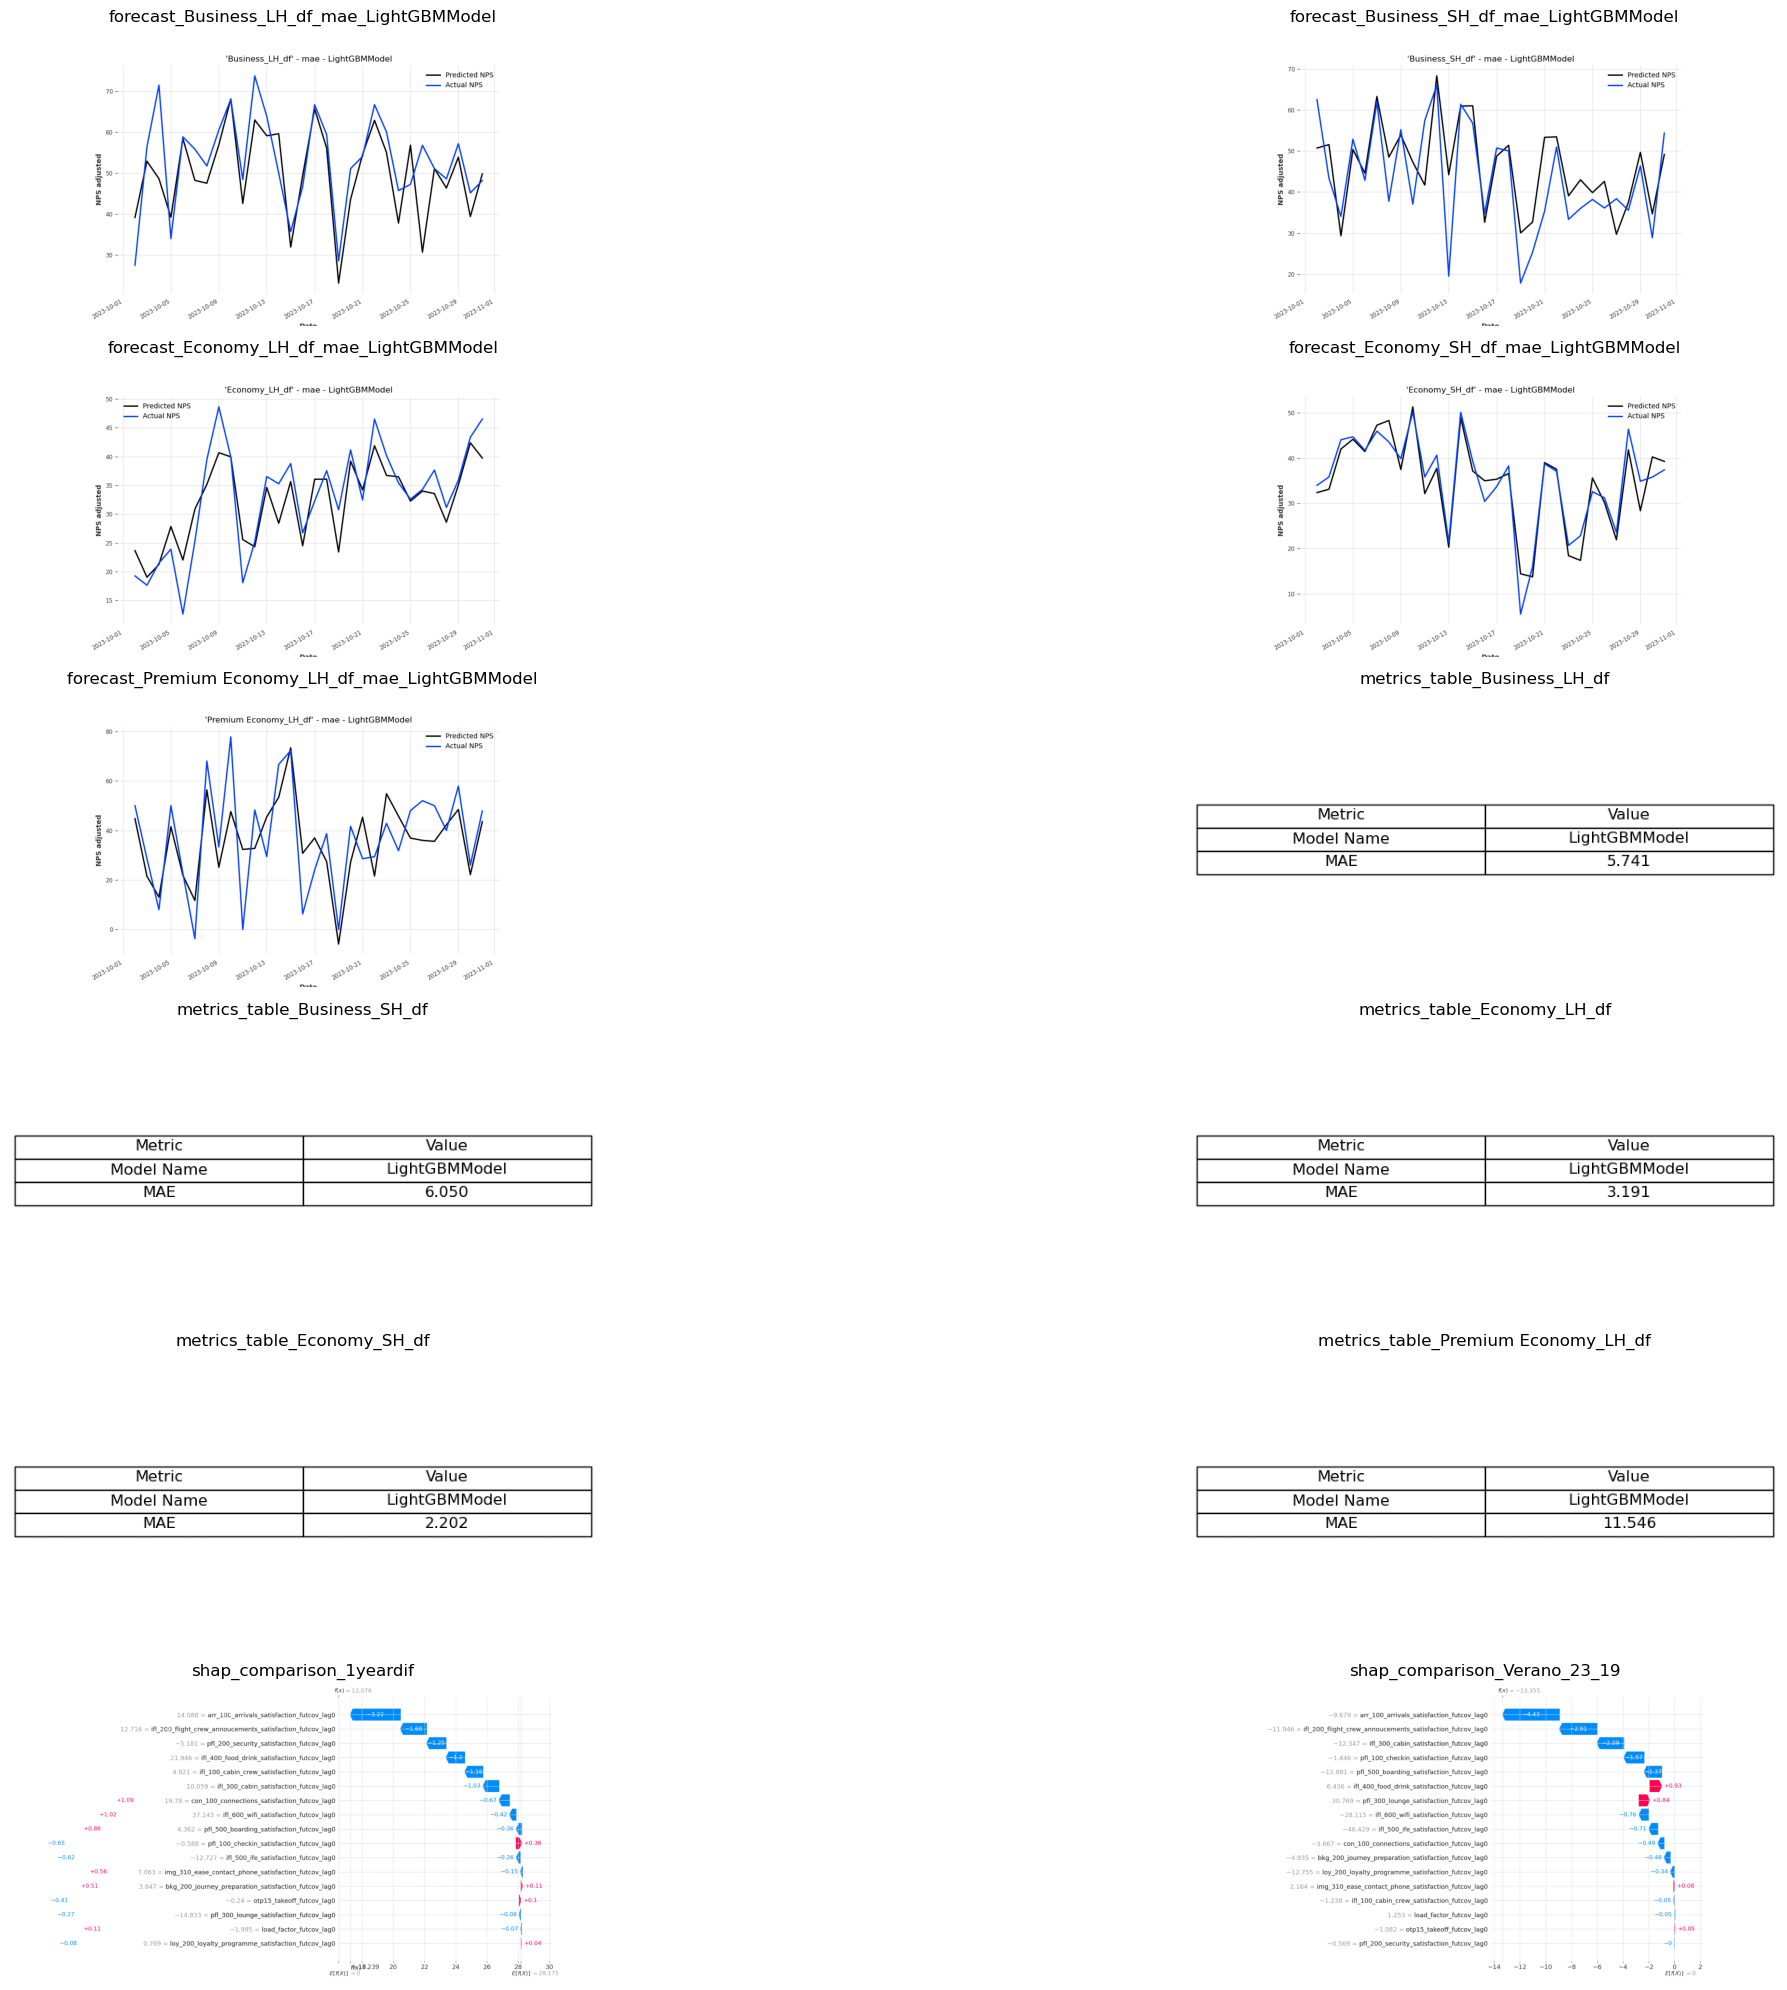

In [38]:
# Example usage:

combine_and_save_plots(f"{tuned_output_dir[key]}", f"{key}_report.png")